In [2]:
# Find out which file directory we are currently in:
!pwd

/content/datalab/GCP-SamGu/Lab


### Google's Inception-v3 Deep Neural Network Model

The pre-trained deep learning model that will be used is Inception-v3. It has been developed by Google and has been trained for the ImageNet Competition using the data from 2012. We chose this model because of its high classification performance and because it is easily available in TensorFlow.

We have downloaded the pre-trained DCNN model at 'reference/reusable_model' directory.
If you want to re-download this model, run: !python ./reference/classify_image.py --model_dir ./reference/reusable_model

The customer's images are in the 'images' directory.

In [4]:
# !python ./reference/classify_image.py --model_dir ./reference/reusable_model

>> Downloading inception-2015-12-05.tgz 100.0%
Successfully downloaded inception-2015-12-05.tgz 88931400 bytes.
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE3 instructions, but these are available on your machine and could speed up CPU computations.
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
W tensorflow/core/framework/op_def_util.cc:332] Op BatchNormWithGlobalNormalization is deprecated. It will ce

### Download customer image data:

In [5]:
# !git clone https://github.com/telescopeuser/images.git

### Start Deep Learning & Transfer Learning

In [6]:
import os
import re

import tensorflow as tf
import tensorflow.python.platform
from tensorflow.python.platform import gfile
import numpy as np
import pandas as pd
import sklearn
from sklearn import cross_validation
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC, LinearSVC
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [9]:
model_dir = 'reference/reusable_model'
images_dir = 'images/'
list_images = [images_dir+f for f in os.listdir(images_dir) if re.search('jpg|JPG', f)]

In [10]:
print('Number of Customer\'s Images       : %d' % len(list_images))

Number of Customer's Images       : 0


To use TensorFlow, you should define a graph that represents the description of computations. Then these computations will be executed within what is called sessions. If you want to know more about the basics of TensorFlow, you can go here.

The following function creates a graph from the graph definition that we just downloaded and that is saved in classify_image_graph_def.pb

In [4]:
def create_graph():
  with gfile.FastGFile(os.path.join(model_dir, 'classify_image_graph_def.pb'), 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(graph_def, name='')

Then, the next step is to extract relevant features.

To do so, we retrieve the next-to-last layer of the Inception-v3 as a feature vector for each image. Indeed, the last layer of the convolutional neural network corresponds to the classification step: as it has been trained for the ImageNet dataset, the categories that it will be output will not correspond to the categories in the Product Image Classification dataset we are interested in.

The output of the next-to-last layer, however, corresponds to features that are used for the classification in Inception-v3. The hypothesis here is that these features can be useful for training another classification model, so we extract the output of this layer. In TensorFlow, this layer is called pool_3.

The following function returns the features corresponding to the output of this next-to-last layer and the labels for each image.

In [11]:
def extract_features(list_images):
  nb_features = 2048 # Deep Features
  features = np.empty((len(list_images),nb_features))
  labels = []

  create_graph()
  
  with tf.Session() as sess:
    next_to_last_tensor = sess.graph.get_tensor_by_name('pool_3:0')
    
    for ind, image in enumerate(list_images):
      if (ind%20 == 0):
        print('Processing %s...' % (image))
        if not gfile.Exists(image):
          tf.logging.fatal('File does not exist %s', image)
          
        image_data = gfile.FastGFile(image, 'rb').read()
        predictions = sess.run(next_to_last_tensor,
                               {'DecodeJpeg/contents:0': image_data})
        features[ind,:] = np.squeeze(predictions)
        labels.append(re.split('_\d+',image.split('/')[1])[0]) # Naming Convention: Class Lable + Digits + .jpg|JPG
          
    print('Processing Completed !')
    return features, labels


In [12]:
features,labels = extract_features(list_images)

Processing images/abnormal_valve_78.jpg...
Processing images/normal_valve_13.jpg...
Processing images/abnormal_valve_11.jpg...
Processing images/normal_valve_63.jpg...
Processing images/abnormal_valve_47.jpg...
Processing images/normal_valve_31.jpg...
Processing images/normal_valve_65.jpg...
Processing images/normal_valve_56.jpg...
Processing images/normal_valve_48.jpg...
Processing images/normal_valve_26.jpg...
Processing images/normal_valve_73.JPG...
Processing images/abnormal_valve_23.jpg...
Processing images/abnormal_valve_45.jpg...
Processing images/normal_valve_10.jpg...
Processing images/normal_valve_74.JPG...
Processing images/abnormal_valve_58.jpg...
Processing images/normal_valve_30.jpg...
Processing images/abnormal_valve_39.jpg...
Processing images/abnormal_valve_68.jpg...
Processing images/normal_valve_34.jpg...
Processing images/abnormal_valve_67.jpg...
Processing images/abnormal_valve_35.jpg...
Processing images/normal_valve_14.jpg...
Processing images/normal_valve_71.jpg

In [23]:
print('Number of Images                   : %d' % len(features))
print('Number of Deep Features per Images : %d' % len(features[0]))
print('Unique Image Classess (Labels)     : %s' % list(set(labels)))

Number of Images                   : 168
Number of Deep Features per Images : 2048
Unique Image Classess (Labels)     : ['abnormal_valve', 'normal_valve']


Then the features and labels are saved, so they can be used without re-running this step.

In [21]:
pickle.dump(features, open('features', 'wb'))
pickle.dump(labels, open('labels', 'wb'))

### Classification based on the features computed using TensorFlow

We will now use the features that we just computed with TensorFlow to train a classifier on the images. Another strategy could be to re-train the last layer of the CNN in TensorFlow, as shown here in TensorFlow tutorials and here for the python version.

### Prepare training and test datasets:

In [24]:
features = pickle.load(open('features'))
labels = pickle.load(open('labels'))

### We will use 80% of the data as the training set and 20% as the test set.

In [32]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(features, labels, test_size=0.3, random_state=42)

### Classifying the images with a Linear Support Vector Machine (SVM):
We chose to use a linear SVM to classify the images into the 2 categories using the features computed with TensorFlow. We used the LinearSVC implementation with the default parameters.

In [33]:
clf = LinearSVC(C=1.0, loss='squared_hinge', penalty='l2',multi_class='ovr')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

### Evaluation: We will plot the confusion matrix (computed with scikit-learn) to visualize the classification performance, on top of the accuracy score.

In [34]:
def plot_confusion_matrix(y_true,y_pred):
  cm_array = confusion_matrix(y_true,y_pred)
  true_labels = np.unique(y_true)
  pred_labels = np.unique(y_pred)
  plt.imshow(cm_array[:-1,:-1], interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion matrix", fontsize=16)
  cbar = plt.colorbar(fraction=0.046, pad=0.04)
  cbar.set_label('Number of images', rotation=270, labelpad=30, fontsize=12)
  xtick_marks = np.arange(len(true_labels))
  ytick_marks = np.arange(len(pred_labels))
  plt.xticks(xtick_marks, true_labels, rotation=90)
  plt.yticks(ytick_marks,pred_labels)
  plt.tight_layout()
  plt.ylabel('True label', fontsize=14)
  plt.xlabel('Predicted label', fontsize=14)
  fig_size = plt.rcParams["figure.figsize"]
  fig_size[0] = 12
  fig_size[1] = 12
  plt.rcParams["figure.figsize"] = fig_size

In [36]:
def plot_confusion_matrix(y_true,y_pred):
  cm_array = confusion_matrix(y_true,y_pred)
  true_labels = np.unique(y_true)
  pred_labels = np.unique(y_pred)
  plt.imshow(cm_array[:-1,:-1], interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion matrix", fontsize=16)
  cbar = plt.colorbar(fraction=0.046, pad=0.04)
  cbar.set_label('Number of images', rotation=270, labelpad=30, fontsize=12)
  xtick_marks = np.arange(len(true_labels)-1)
  ytick_marks = np.arange(len(pred_labels)-1)
  plt.xticks(xtick_marks, true_labels, rotation=90)
  plt.yticks(ytick_marks,pred_labels)
  plt.tight_layout()
  plt.ylabel('True label', fontsize=14)
  plt.xlabel('Predicted label', fontsize=14)
  fig_size = plt.rcParams["figure.figsize"]
  fig_size[0] = 12
  fig_size[1] = 12
  plt.rcParams["figure.figsize"] = fig_size

Accuracy: 92.2%


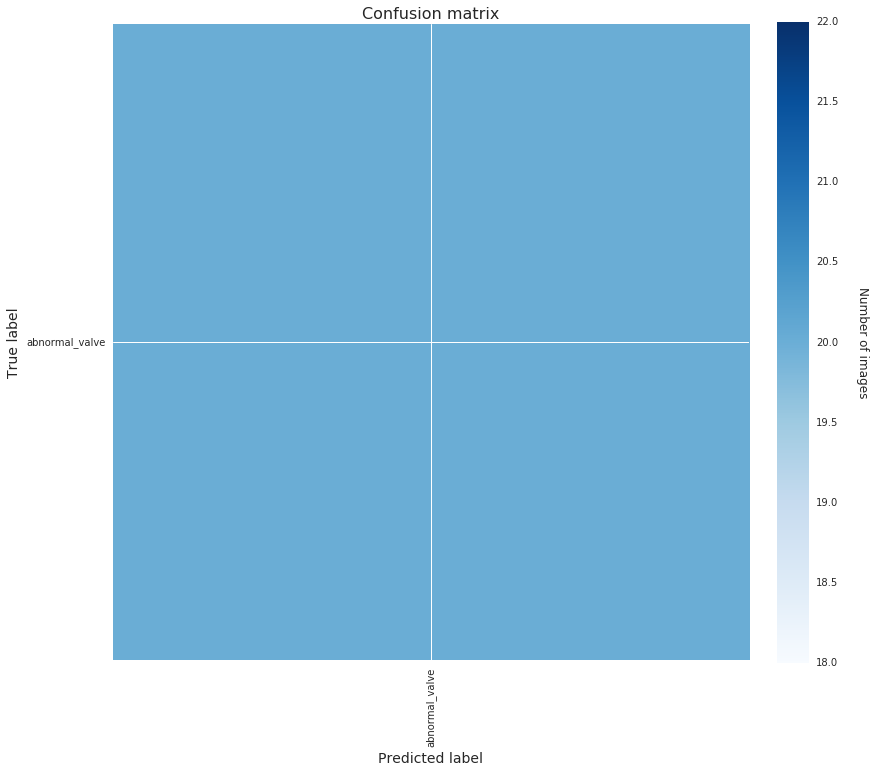

In [37]:
print("Accuracy: {0:0.1f}%".format(accuracy_score(y_test,y_pred)*100))
plot_confusion_matrix(y_test,y_pred)

The classification accuracy is 94.1 % on the test set, which is quite impressive, especially as it does not require so much work on our side !